# Imports and utils

In [69]:
import gxgp
from gxgp import *
import operator
import numpy as np  
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
import os


def sin(x):
        return np.sin(x)
def cos(x):
        return np.cos(x)
def exp(x):
        return np.exp(x)
def tanh(x):
    return np.tanh(x)
def sinh(x):
    return np.sinh(x)
def cosh(x):
    return np.cosh(x)
def arctan(x):
    return np.arctan(x)

Modify the `selected` parameter in order to try different datasets

In [ ]:
selected = 8

operators = {
    0: [operator.add, operator.sub, operator.mul, sin, cos],
    1: [operator.add, operator.sub, operator.mul, sin, cos],
    2: [operator.add, operator.sub, operator.mul, sin, cos, exp, sinh, cosh, tanh, arctan],
    3: [operator.add, operator.sub, operator.mul, sin, cos],
    4: [operator.add, operator.sub, operator.mul, sin, cos],
    5: [operator.add, operator.sub, operator.mul, sin, cos, exp],
    6: [operator.add, operator.sub, operator.mul, sin, cos],
    7: [operator.add, operator.sub, operator.mul, sin, cos, exp, sinh, cosh, tanh, arctan],
    8: [operator.add, operator.sub, operator.mul, sin, cos, exp, sinh, cosh, tanh, arctan],
}

parameters = {
    # Population size, generations, offspring size, individual size, tournament size, resize factor, mutation const, mutation rate, length penalty, crossover rate
    0: [100, 200, 30, 6, 5, 500, 0.25,    0, 5e-3, 0.5], # definitive
    1: [100,  50, 30, 6, 5, 500, 0.25,    0,    0, 0.5], # definitive
    2: [100, 400, 30, 6, 5, 500,  0.2,  0.5,    0, 0.5], # definitive
    3: [100, 400, 30, 6, 5, 500,  0.5,    0, 1e-2, 0.5], # definitive
    4: [100, 300, 30, 6, 5, 500, 0.25,    0, 1e-2, 0.5], # definitive
    5: [100, 500, 30, 6, 5, 500,  0.5,    0, 1e-2, 0.5], # definitive
    6: [100, 400, 30, 6, 5, 500, 0.25,    0, 1e-3, 0.5], # definitive
    7: [100, 300, 30, 6, 5, 5000, 0.4,  0.2, 1e-2, 0.5], # definitive
    8: [100, 500, 30, 6, 5, 5000, 0.5,    0, 1e-2, 0.5], # definitive
}


In [71]:
operators = operators[selected]
POPULATION_SIZE, GENERATIONS, OFFSPRING_SIZE, INDIVIDUAL_SIZE, TOURNAMENT_SIZE, RESIZE, MUT_A, MUT_B, LEN_PENALTY, CROSSOVER_RATE= parameters[selected]

`RESIZE` is used to downsample the original data, in order to make computation faster 

In [72]:
problem = np.load(f'../data/problem_{selected}.npz')
x = problem['x']
y = problem['y']
print(x.shape, y.shape)

if y.shape[0] > RESIZE:
    step = y.shape[0] // RESIZE  # Determine step size
    truth = y[::step]  # Take every `step`-th element
    truth = truth[:RESIZE]
    x = x[:, ::step]
    x = x[:, :RESIZE]
else:
    truth = y

print(x.shape, truth.shape)

# Initialize DagGP with callable operators and functions
gp = gxgp.DagGP(
    operators=operators,
    variables=x.shape[0],
    constants=np.linspace(-2, 2, 500),
)

(6, 50000) (50000,)
(6, 5000) (5000,)


The following function is used to map the output to a real numpy expression, that can be copied and pasted in the destination file

In [73]:
def transform_expression(expr):
    operator_map = {
        'add': 'np.add',
        'sub': 'np.subtract',
        'mul': 'np.multiply',
        'safe_div': 'np.divide',
        'safe_log': 'np.log',
        'exp': 'np.exp',
        'sin': 'np.sin',
        'cos': 'np.cos',
        'tan': 'np.tan',
        'abs': 'np.abs',
        'tanh': 'np.tanh',
        'sinh': 'np.sinh',
        'cosh': 'np.cosh',
        'arctan': 'np.arctan',
    }
    # Base case: If it's a number, return as is
    if re.fullmatch(r'[-+]?\d*\.?\d+', expr):  
        return expr
    
    # Replace variables x0, x1, x2, ... with x[0], x[1], x[2], ...
    if re.fullmatch(r'x\d+', expr):
        return f"x[{expr[1:]}]"

    # Match function calls like: func(arg1, arg2)
    match = re.match(r'(\w+)\((.+)\)', expr)
    if match:
        func, args_str = match.groups()

        # Split arguments, keeping nested function calls intact
        args = []
        depth = 0
        arg = ""
        for char in args_str:
            if char == ',' and depth == 0:  # Split at top-level commas only
                args.append(arg.strip())
                arg = ""
            else:
                if char == '(': depth += 1
                if char == ')': depth -= 1
                arg += char
        if arg:
            args.append(arg.strip())

        # Recursively process arguments
        transformed_args = [transform_expression(arg) for arg in args]

        # Replace function name with NumPy equivalent
        if func in operator_map:
            return f"{operator_map[func]}({', '.join(transformed_args)})"
        else:
            raise ValueError(f"Unknown function: {func}")

    return expr  # Should not reach here normally

# Tournament selection and fitness

A simple tournament selection is implemented

In [74]:
def tournament_selection(population):
    tournament = np.random.choice(population, TOURNAMENT_SIZE)
    return max(tournament, key=lambda x: x.fitness)

I used MSE and length as the fitness, sometimes I also add a length penalty

In [75]:

def fitness(individual):
    return (-100*gp.mse(individual, x, truth, variable_names=[f'x{i}' for i in range(x.shape[0])])*(1 + LEN_PENALTY * len(individual)) , -len(individual))


# Mutation and crossover

Mutation and crossover functions are in `gxgp`.

In [76]:
def mutate(tree: Node, probability: float) -> Node:
    if gxgp_random.random() < probability:
        return mutate_random_points(tree, x.shape[0], operators, 0.1)
    else:
        return mutate_subtree(tree, x.shape[0], operators)


# Evaluation loop

In [77]:
population = [gp.create_individual(INDIVIDUAL_SIZE) for _ in tqdm(range(POPULATION_SIZE))]
for i in population:
    i.fitness = fitness(i)

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
history = []

In [79]:
for generation in tqdm(range(GENERATIONS)):
    offspring = []
    for _ in range(OFFSPRING_SIZE):
        parent1 = tournament_selection(population)
        if np.random.rand() < CROSSOVER_RATE:
            parent2 = tournament_selection(population)
            children = xover_swap_subtree(parent1, parent2)
            offspring.append(children)
        else:
            mutation1 = mutate(parent1, MUT_A + MUT_B * (generation / GENERATIONS))
            offspring.append(mutation1)
    for i in offspring:
        i.fitness = fitness(i)
        
    if generation % 25 == 0:
        print(f"Generation {generation}, best fitness: {population[0].fitness}")

    population = sorted(population + offspring, key=lambda x: x.fitness, reverse=True)[:POPULATION_SIZE]
    history.append(population[0].fitness)


  0%|          | 0/500 [00:00<?, ?it/s]

Generation 0, best fitness: (np.float64(-2255539752.270967), -6)


C:\Users\avant\AppData\Local\Temp\ipykernel_1952\766337574.py:20: RuntimeWarning: overflow encountered in sinh
  return np.sinh(x)
d:\Università\Computational Intelligence\CI2024_project\src\gxgp\gp_dag.py:75: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y - y_pred))


Generation 25, best fitness: (np.float64(-662060010.071248), -6)


C:\Users\avant\AppData\Local\Temp\ipykernel_1952\766337574.py:22: RuntimeWarning: overflow encountered in cosh
  return np.cosh(x)
d:\Università\Computational Intelligence\CI2024_project\src\gxgp\node.py:33: RuntimeWarning: overflow encountered in scalar multiply
  return node(*_args)
C:\Users\avant\AppData\Local\Temp\ipykernel_1952\766337574.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


Generation 50, best fitness: (np.float64(-242926474.6680818), -18)
Generation 75, best fitness: (np.float64(-238255245.44804123), -16)
Generation 100, best fitness: (np.float64(-231518134.53690594), -17)
Generation 125, best fitness: (np.float64(-229679937.07259297), -19)
Generation 150, best fitness: (np.float64(-226444904.21741453), -28)
Generation 175, best fitness: (np.float64(-206744969.95604014), -34)
Generation 200, best fitness: (np.float64(-181839139.38351557), -36)
Generation 225, best fitness: (np.float64(-180998839.98593506), -36)
Generation 250, best fitness: (np.float64(-180329870.41361588), -34)
Generation 275, best fitness: (np.float64(-178717745.64179966), -32)
Generation 300, best fitness: (np.float64(-178175961.01899633), -32)
Generation 325, best fitness: (np.float64(-177335388.01961252), -32)
Generation 350, best fitness: (np.float64(-176368397.8143446), -30)
Generation 375, best fitness: (np.float64(-175557981.96196845), -29)
Generation 400, best fitness: (np.floa

## Final formula

In [80]:
print(transform_expression(population[0].long_name))

np.multiply(1.20147, np.subtract(np.subtract(np.subtract(np.multiply(1.43941, np.multiply(1.08406, np.sinh(np.add(x[5], x[5])))), np.multiply(1.82463, np.cosh(np.multiply(x[4], 1.43941)))), np.cosh(np.multiply(x[4], 1.43941))), np.cosh(np.multiply(x[4], 1.43941))))


# Plots

In [81]:
SAVE = False

In [82]:
# Create directory if it does not exist
directory = f'../images/problem{selected}'
if not os.path.exists(directory):
    os.makedirs(directory)

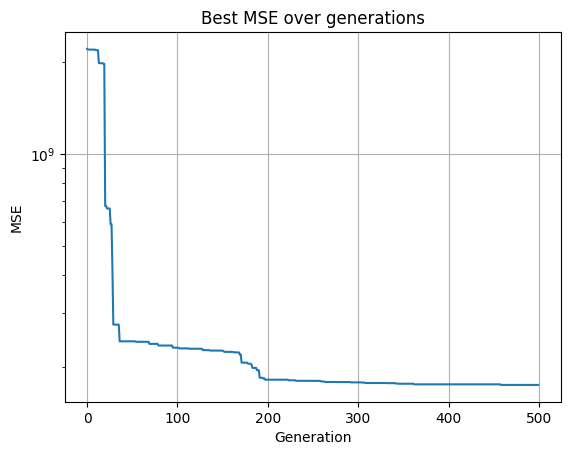

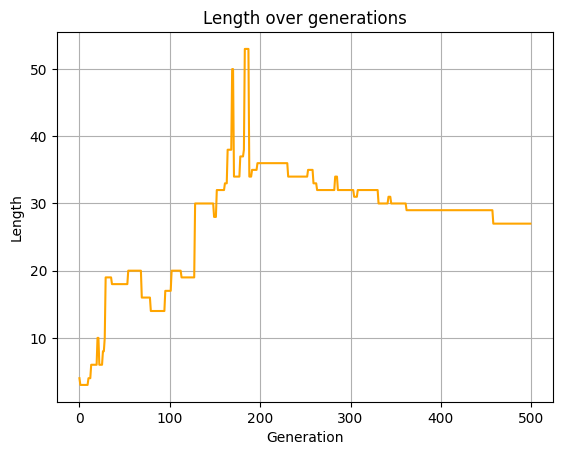

In [83]:
# Extract MSE and Length from history
mse_history = [-h[0] for h in history]
length_history = [-h[1] for h in history]

plt.plot(mse_history)
plt.title('Best MSE over generations')
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.yscale('log')
plt.grid()
if SAVE:
    plt.savefig(f'../images/problem{selected}/mse.png')
plt.show()

plt.plot(length_history, color='orange')
plt.title('Length over generations')
plt.xlabel('Generation')
plt.ylabel('Length')
plt.grid()
if SAVE:
    plt.savefig(f'../images/problem{selected}/length.png')
plt.show()

In [84]:
index, max_value = history.index(max(history)), max(history)
print(f"Max fitness value reached at epoch {index}, Max fitness value: {max_value}")

Max fitness value reached at epoch 458, Max fitness value: (np.float64(-174787238.19195923), -27)


The following cell plots the graph of the formula

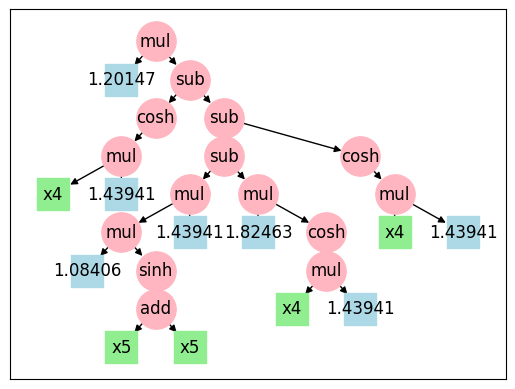

In [85]:
population[0].draw()
if SAVE:
    plt.savefig(f'../images/problem{selected}/formula.png')

The following plots are obtained by setting all the variables to 0 except for the plotted one

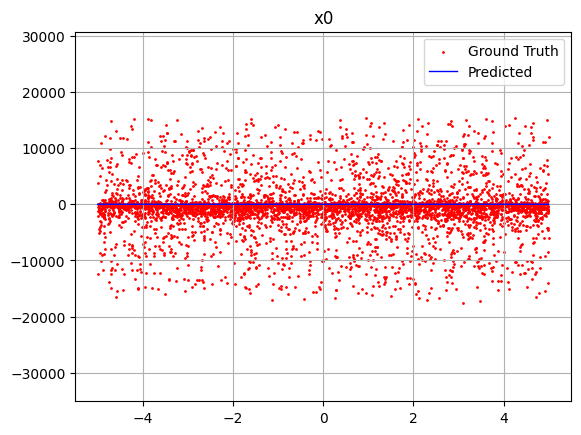

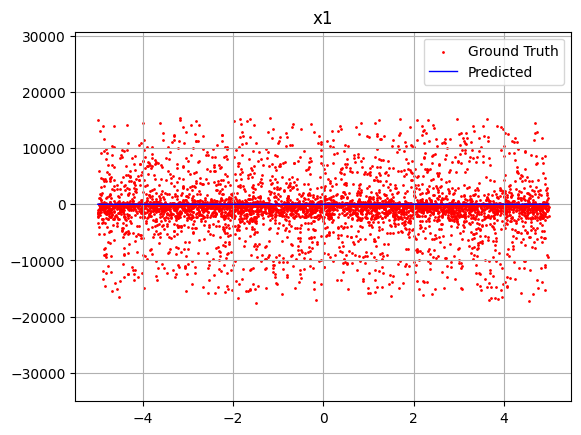

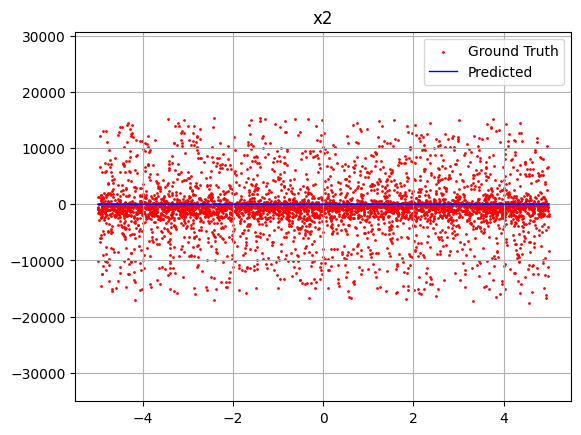

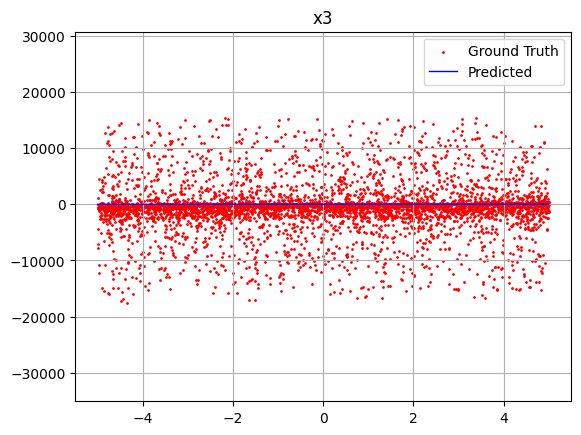

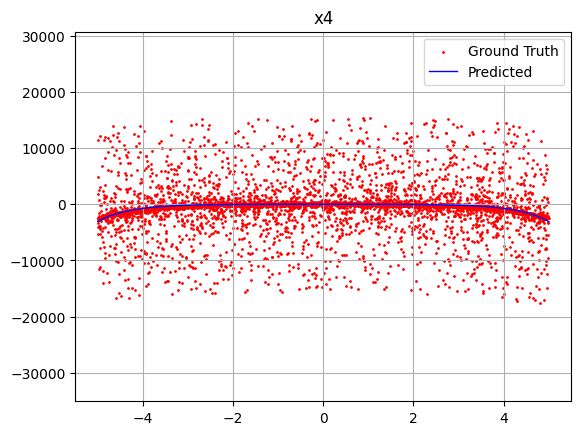

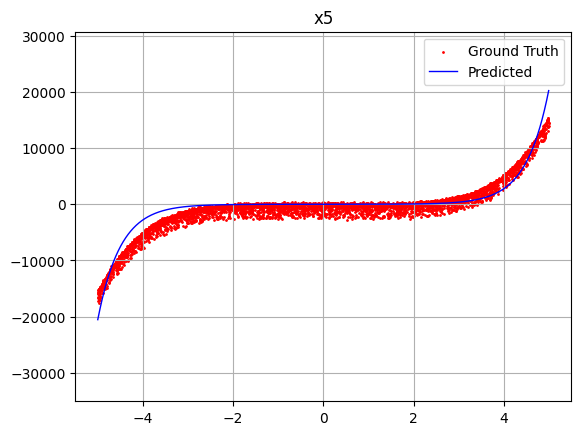

In [86]:
y_max = max(truth)
y_min = min(truth)

for i in range(x.shape[0]):
    x_min = min(x[i])
    x_max = max(x[i])
    interval = np.linspace(x_min, x_max, 2000)

    # Generate predicted values for the interval using the population model.
    predicted = [population[0](**{f'x{k}': interval[j] if k==i else 0 for k in range(x.shape[0])}) for j in range(len(interval))]
    
    plt.ylim(2*y_min, 2*y_max)

    plt.title(f'x{i}')
    plt.scatter(x[i], truth, s=1, c='r')   # Scatter plot for the original points
    plt.plot(interval, predicted, c='b', linewidth=1)   # Blue line for the predicted values on the interval
    plt.grid(True)

    plt.legend(['Ground Truth', 'Predicted'])
    if SAVE:
        plt.savefig(f'../images/problem{selected}/x{i}.png')
    plt.show()


If `x` is 2 dimensional, the following cell outputs a 3D plot

In [87]:
if x.shape[0] == 2:
    #%matplotlib widget
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Assuming x has at least 2 dimensions for 3D plotting
    x1 = x[0]
    x2 = x[1]

    # Generate predicted values for the 3D plot using the population model.
    predicted = [population[0](**{f'x0': x1[j], f'x1': x2[j]}) for j in range(len(x1))]

    ax.scatter(x1, x2, truth, c='r', marker='o', s=1)  # Scatter plot for the original points
    ax.plot_trisurf(x1, x2, predicted, color='b', alpha=0.5)  # Surface plot for the predicted values

    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_zlabel('Y')
    plt.title('3D Plot')
    if SAVE:
        plt.savefig(f'./images/problem{selected}/3d.png')
    plt.show()

    #%matplotlib inline